In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import resize as Resize
from msdlib import mlutils, msd
from IPython.core.display import HTML
import os
import time
from PIL import Image

C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None

## Parameters

In [3]:
data_dir = 'E:\\Data sets\\MNIST'
batch_size = 128
epoch = 200
learning_rate = .0001
sample_interval = 300
device = 'cuda'
dtype = torch.float32
hidden_dim = 10
step = 5
gamma = .98
validation_ratio = .1

## Loading training data 

data can be found here https://www.kaggle.com/competitions/digit-recognizer/data

In [4]:
data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

## Training data processing

In [5]:
dimension = int((data.shape[1] - 1)**.5)
if torch.cuda.is_available() and device == 'cuda':
    device = 'cuda'
else:
    device= ' cpu'

In [6]:
label = data['label'].values.copy()
data.drop('label', axis=1, inplace=True)

In [7]:
data = torch.tensor(data.values, device=device, dtype=dtype).view(-1, 1, dimension, dimension)
data = ((data / 255) - .5) * 2
data.shape

torch.Size([42000, 1, 28, 28])

## Training data visualization

2


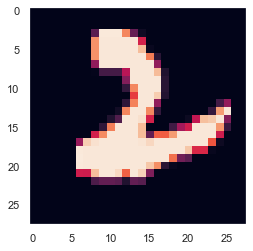

4


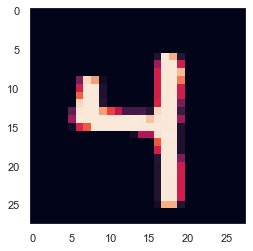

3


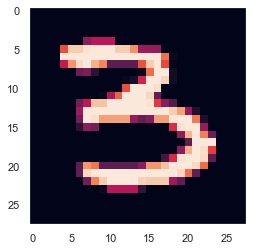

6


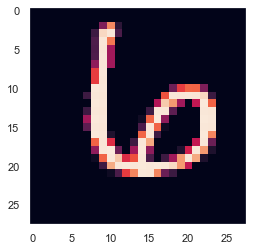

7


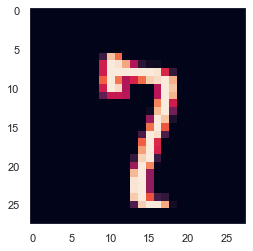

3


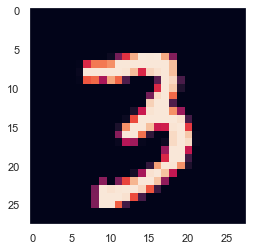

2


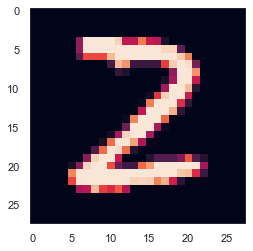

5


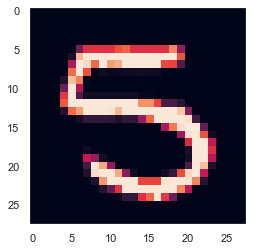

6


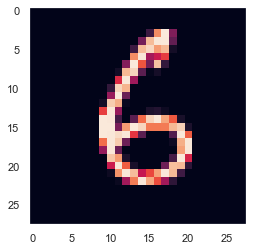

3


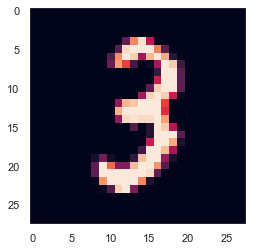

In [8]:
for i in range(10):
    i = np.random.randint(data.shape[0])
    print(label[i])
    plt.Figure()
    plt.imshow(data[i, 0].cpu())
    plt.grid(False)
    plt.show()

## User defined Functions

In [9]:
def denormalize(data):
    return (((data / 2) + .5) * 255)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

## Auto-Encoder model definition

In [10]:
class AE(torch.nn.Module):
    
    def __init__(self, input_height, input_width, input_channel, hidden_dim):
        
        super(AE, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_channel = input_channel
        self.hidden_dim = hidden_dim
        
        self.define_model()
        
    def define_model(self,):
        
        self.encoder_conv = torch.nn.Sequential(
            torch.nn.Conv2d(self.input_channel, 64, 5, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=.05),
            torch.nn.Conv2d(64, 16, 3, padding='same'),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(negative_slope=.05),
            torch.nn.Conv2d(16, 4, 1, padding='same'),
            torch.nn.BatchNorm2d(4),
            torch.nn.LeakyReLU(negative_slope=.05),
        )
        
        self.encoder_lin = torch.nn.Sequential(
            torch.nn.Linear(self.input_height * self.input_width * 4, self.hidden_dim),
            torch.nn.Softmax(dim=-1)
        )
        
        self.decoder_lin = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, self.input_height * self.input_width * 4),
            torch.nn.BatchNorm1d(self.input_height * self.input_width * 4),
            torch.nn.LeakyReLU(negative_slope=.05)
        )
        
        self.decoder_conv = torch.nn.Sequential(
            torch.nn.Conv2d(4, 16, 1, padding='same'),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(negative_slope=.05),
            torch.nn.Conv2d(16, 64, 3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=.05),
            torch.nn.Conv2d(64, self.input_channel, 5, padding='same'),
            torch.nn.BatchNorm2d(self.input_channel),
            torch.nn.Tanh(),
        )
        
    def encode(self, x):
        
        x = self.encoder_conv(x)
        x = x.view(-1, self.input_height * self.input_width * 4)
        x = self.encoder_lin(x)
        
        return x
    
    def decode(self, x):
        x = self.decoder_lin(x)
        x = x.view(-1, 4, self.input_height, self.input_width)
        x = self.decoder_conv(x)
        
        return x
    
    def forward(self, x):
        
        x = self.encode(x)
        x = self.decode(x)
        
        return x

## Model trainer class definition

In [12]:
class AETrainer():
    
    def __init__(self, input_height, input_width, input_channel, hidden_dim=10, learning_rate=.0001, epoch=100, batch_size=64, 
                 step=1, gamma=1, sample_intv=500, validation_ratio=.1, device='cuda', dtype=torch.float32):
        
        self.hidden_dim = hidden_dim
        self.input_channel = input_channel
        self.input_height = input_height
        self.input_width = input_width
        self.lr = learning_rate
        self.epoch = epoch
        self.batch_size = batch_size
        self.dtype = dtype
        self.device = device
        self.step = step
        self.gamma = gamma
        self.sample_intv = sample_intv
        self.validation_ratio = validation_ratio
        
        self.ae_model = AE(self.input_height, self.input_width, self.input_channel, self.hidden_dim).to(device=device, dtype=dtype)
        self.load_model()
        self.set_optimizerNloss()
    
    def set_optimizerNloss(self):
        self.opt = torch.optim.Adam(self.ae_model.parameters(), lr=self.lr)
        self.sch = torch.optim.lr_scheduler.StepLR(self.opt, self.step, self.gamma, verbose=False)
        self.loss_func = torch.nn.MSELoss(reduction='mean')
        
    def split_data(self, data):
        index = np.random.permutation(np.arange(data.shape[0]))
        train_len = int(data.shape[0] * (1 - self.validation_ratio))
        train_loader = torch.utils.data.DataLoader(data[:train_len], batch_size=self.batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(data[train_len:], batch_size=self.batch_size, shuffle=True)
        
        return train_loader, val_loader
    
    def train(self, data):
        data = data.to(device=self.device, dtype=self.dtype)
        train_loader, val_loader = self.split_data(data)
        
        self.losses = {'train': [np.nan], 'validation': [np.nan]}
        
        self.total_batch = len(train_loader)
        t1 = time.time()
        c = 0
        for ep in range(self.epoch):
            _loss = []
            self.ae_model.train()
            for i, batch_data in enumerate(train_loader):
                
                # discriminator loss
                self.ae_model.zero_grad()
                d_out = self.ae_model(batch_data)
                loss = self.loss_func(d_out, batch_data)
                loss.backward()
                self.opt.step()
                _loss.append(loss.item())
                
                time_string = msd.get_time_estimation(time_st=t1, current_ep=ep, current_batch=i, total_ep=self.epoch, total_batch=self.total_batch)
                print('\repoch : %04d/%04d, batch : %03d, train_loss : %.4f, validation_loss : %.4f,  %s'
                      % (ep + 1, self.epoch, i + 1, loss.item(), self.losses['validation'][-1], time_string)+' '*20, end='', flush=True)
                if c % self.sample_intv == 0:
                    self.take_samples(data, ep+1, i+1)
                c += 1
            
            self.losses['train'].append(np.mean(_loss))
            d_out = self.predict(val_loader)
            val_data = torch.vstack([_data for _data in val_loader])
            valloss = self.loss_func(d_out, val_data)
            self.losses['validation'].append(valloss.item())
            self.sch.step()
        self.save_ckpt()
        
    def predict(self, loader):
        preds = []
        self.ae_model.eval()
        with torch.no_grad():
            for batch_data in loader:
                preds.append(self.ae_model(batch_data))
            preds = torch.vstack(preds)
        return preds
    
    def plot_learning_curve(self):
        self.losses['train'] = self.losses['train'][1:]
        self.losses['validation'] = self.losses['validation'][1:]
        losses = pd.DataFrame(self.losses)
        losses.index += 1
        same_srs = [losses[c] for c in losses.columns]
        msd.plot_time_series(same_srs=same_srs, show=True, segs=1)
    
    def take_samples(self, data, ep, batch):
        outdir = 'samples'
        os.makedirs(outdir, exist_ok=True)
        loader = torch.utils.data.DataLoader(data[np.random.permutation(np.arange(data.shape[0]))[:120]], batch_size=self.batch_size, shuffle=True)
        d_out = self.predict(loader)
        d_out = d_out.view(-1, 10, self.input_height, self.input_width, self.input_channel).detach().cpu().numpy()
        final_image = []
        for i in range(d_out.shape[0]):
            image_row = []
            for j in range(d_out.shape[1]):
                image_row.append(d_out[i, j])
            image_row = np.concatenate(image_row, axis=1)
            final_image.append(image_row)
        final_image = np.concatenate(final_image, axis=0)
        final_image = np.tile(final_image, (1, 1, 3))
        final_image = denormalize(final_image).astype(np.uint8)
        plt.imsave("%s/epoch-%d_batch-%d.jpg"%(outdir, ep, batch), final_image, cmap='hot')
    
    def save_ckpt(self):
        os.makedirs('models', exist_ok=True)
        torch.save(self.ae_model.state_dict(), 'models/AE-model.pt')
    
    def load_model(self):
        self.ae_model.load_state_dict(torch.load('models/AE-model_best.pt'))

## Trainer initialization with preset parameters

In [13]:
trainer = AETrainer(dimension, dimension, data.shape[1], hidden_dim=hidden_dim, learning_rate=learning_rate, epoch=epoch, batch_size=batch_size, 
                    step=step, gamma=gamma, sample_intv=sample_interval, validation_ratio=validation_ratio, device=device, dtype=dtype)

## Auto-Encoder Training and Learning curve visualization

epoch : 0200/0200, batch : 296, train_loss : 0.1065, validation_loss : 0.4579,  3:03:36 < 0:00:00                    

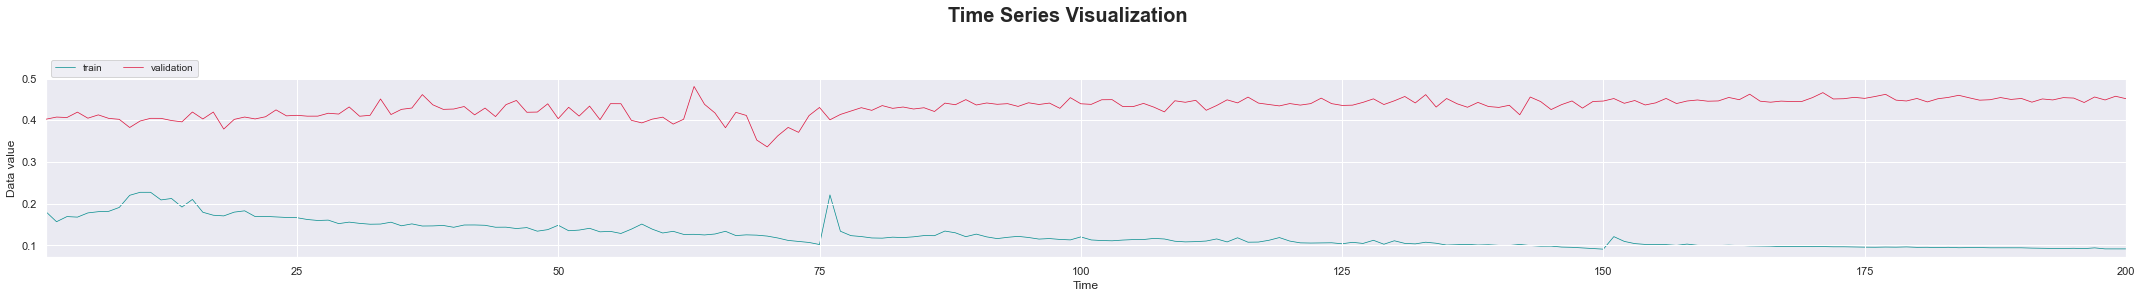

In [57]:
try:
    trainer.train(data)
    trainer.plot_learning_curve()
except KeyboardInterrupt:
    trainer.plot_learning_curve()

## Test data loading and visualization of reconstruction

In [14]:
testdata = pd.read_csv(os.path.join(data_dir, 'test.csv'))
testdata

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [15]:
testdata = torch.tensor(testdata.values, device=device, dtype=dtype).view(-1, 1, dimension, dimension)
testdata = ((testdata / 255) - .5) * 2

encoded tensor: [[0.    0.002 0.992 0.001 0.001 0.001 0.    0.001 0.001 0.001]]


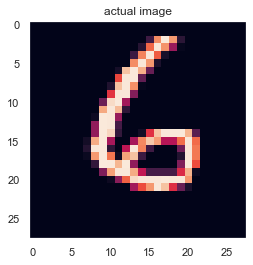

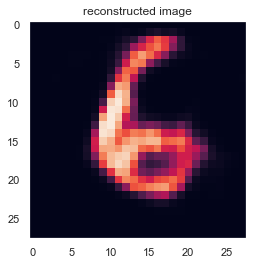

encoded tensor: [[0.001 0.001 0.992 0.002 0.    0.001 0.001 0.002 0.001 0.001]]


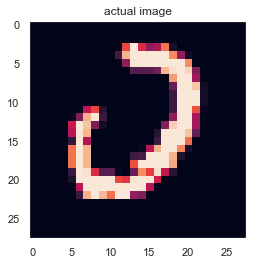

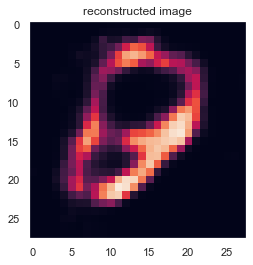

encoded tensor: [[0.001 0.001 0.994 0.001 0.    0.001 0.    0.001 0.001 0.001]]


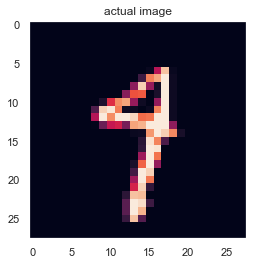

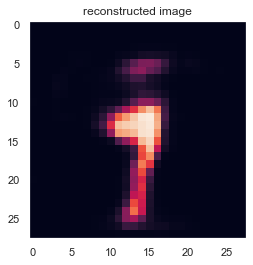

encoded tensor: [[0.001 0.001 0.994 0.001 0.001 0.    0.001 0.001 0.001 0.   ]]


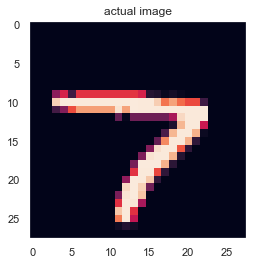

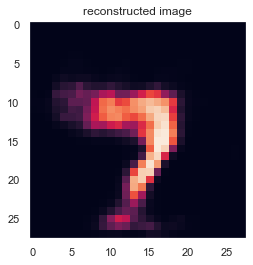

encoded tensor: [[0.001 0.001 0.994 0.001 0.    0.002 0.001 0.001 0.    0.   ]]


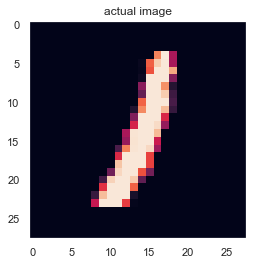

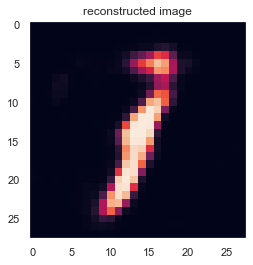

encoded tensor: [[0.001 0.002 0.992 0.001 0.001 0.001 0.    0.001 0.001 0.001]]


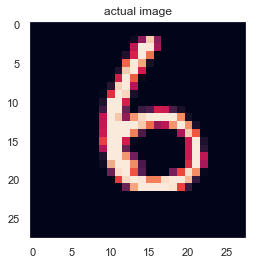

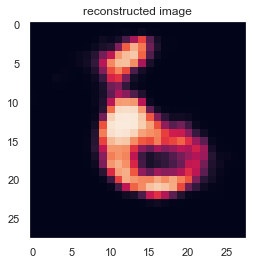

encoded tensor: [[0.001 0.001 0.994 0.001 0.    0.001 0.001 0.001 0.    0.001]]


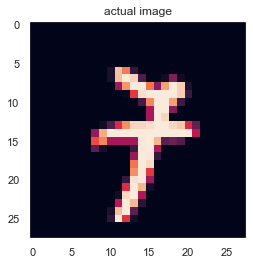

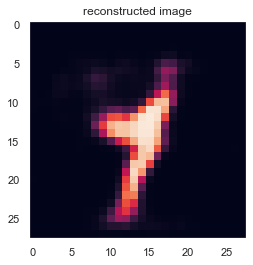

encoded tensor: [[0.001 0.001 0.992 0.001 0.    0.001 0.001 0.001 0.001 0.001]]


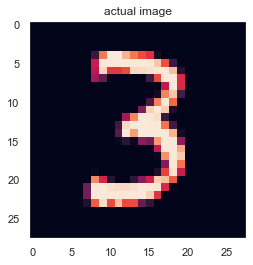

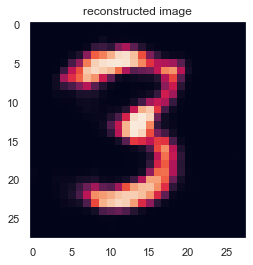

encoded tensor: [[0.    0.    0.995 0.001 0.    0.001 0.001 0.001 0.    0.001]]


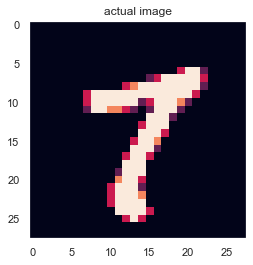

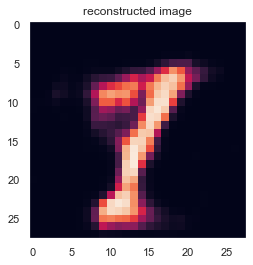

encoded tensor: [[0.001 0.001 0.993 0.001 0.001 0.001 0.    0.001 0.001 0.001]]


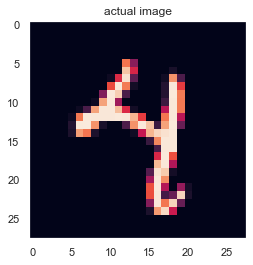

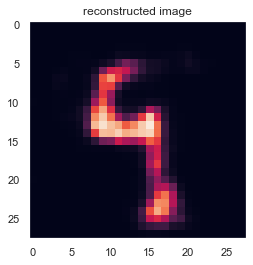

In [29]:
trainer.ae_model.eval()
for i in range(10):
    i = np.random.randint(testdata.shape[0])
    with torch.no_grad():
        encoded = trainer.ae_model.encode(testdata[[i]]).detach().cpu().numpy().round(3)
        output = trainer.ae_model(testdata[[i]]).detach().cpu().numpy()
    print('encoded tensor:', encoded)
    plt.Figure()
    plt.title('actual image')
    plt.imshow(testdata[i, 0].cpu())
    plt.grid(False)
    plt.show()
    
    plt.Figure()
    plt.title('reconstructed image')
    plt.imshow(output[0, 0])
    plt.grid(False)
    plt.show()

## Image clustering using Auto-Encoder's mid hidden layer representation

### Getting Encoder's outputs for training data

In [14]:
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

train_pred = []
for batch in loader:
    train_pred.append(trainer.ae_model.encode(batch).detach())
train_pred = torch.vstack(train_pred)
train_pred.shape

torch.Size([42000, 10])

### importing modules for Dimensionality reduction and visualization

In [17]:
from sklearn.manifold import TSNE
from msdlib import msd

### Applying TSNE

In [16]:
train2d = TSNE(n_components=2).fit_transform(train_pred.cpu().numpy())
train2d.shape

C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(42000, 2)

### Cluster visualization

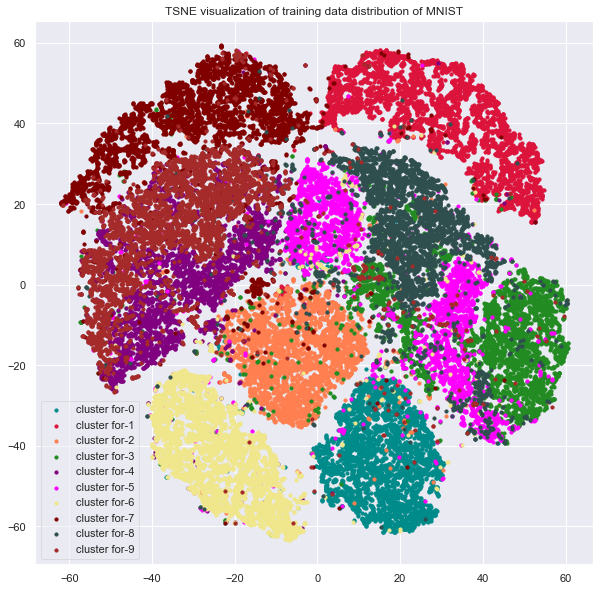

In [23]:
plt.figure(figsize=(10, 10))
plt.title('TSNE visualization of training data distribution of MNIST')
colors = msd.get_named_colors()
lg = [[], []]
for i, value in enumerate(np.sort(np.unique(label))):
    plotdata = train2d[label == value]
    l = plt.scatter(plotdata[:, 0], plotdata[:, 1], color=colors[i], s=10)
    lg[0].append(l)
    lg[1].append('cluster for-%d'%value)
plt.legend(lg[0], lg[1], framealpha=.5)
plt.show()